# Embedding model
- http://users.eecs.northwestern.edu/~jwa368/pdfs/deep_ranking.pdf
- https://papers.nips.cc/paper/4808-hamming-distance-metric-learning.pdf
- https://arxiv.org/pdf/1702.00758.pdf
- face net: https://arxiv.org/pdf/1503.03832.pdf

In [1]:
# TODO: 
# - test on real coins
# - show test loss while training
# - try arc from:
#   - http://users.eecs.northwestern.edu/~jwa368/pdfs/deep_ranking.pdf
#   - https://arxiv.org/pdf/1503.03832.pdf
# - generate static dataset
# - try tf.nn.elu
# - try FractalNet
# - try VGG16

In [2]:
import tensorflow as tf
import numpy as np
from dataset import Dataset
from dbase import DataBase
from augmentator import Augmentator
from visualisation import show_losses, show_similarity

In [3]:
class Model():
    def __init__(self, image_shape, out_dims):
        self.image_shape = image_shape
        self.out_dims    = out_dims
        self._session    = None
        self._graph      = None
        self.scope       = 'embedding'
        
    def _make_nn(self, images, out_dim, reuse):
        USE_BN = False
        def conv2d_maxpool(inputs, filters, name, reuse, kernel_size=[3,3], padding="same", activation=tf.nn.relu):
            l = tf.layers.conv2d(
                inputs      = inputs,
                filters     = filters,
                kernel_size = kernel_size,
                padding     = padding,
                activation  = tf.nn.relu,
                reuse       = reuse,
                name        = name)
            if USE_BN:
                l = tf.layers.batch_normalization(
                    inputs   = l, 
                    reuse    = reuse,
                    training = self.training_pl, 
                    name     = name+'_bn')
            l = tf.layers.max_pooling2d(l, pool_size=[2, 2], strides=2)
            return l
        l = images                                              # 128 x 128 x 1
        l = conv2d_maxpool(l,  16, reuse=reuse, name='conv1')   #  64 x 64  x 16
        l = conv2d_maxpool(l,  32, reuse=reuse, name='conv2')   #  32 x 32  x 32
        l = conv2d_maxpool(l,  64, reuse=reuse, name='conv3')   #  16 x 16  x 64
        l = conv2d_maxpool(l, 128, reuse=reuse, name='conv4')   #   8 x 8   x 128
        l = conv2d_maxpool(l, 256, reuse=reuse, name='conv5')   #   4 x 4   x 256 = 4096
        l = tf.contrib.layers.flatten(l)
        l = tf.layers.dense(l, units=4096, activation=tf.nn.relu, reuse=reuse, name='fc1')
        l = tf.layers.dense(l, units=out_dim, reuse=reuse, name='logits')
        l = tf.nn.l2_normalize(l, dim=1)
        return l

    def _make_loss(self, main, same, diff, margin):
        def dist(a, b):
            return tf.reduce_sum((a-b)**2, axis=1)
        pos_dist = dist(main, same)
        neg_dist = dist(main, diff)
        loss = tf.nn.relu(pos_dist - neg_dist + margin)
        loss = tf.reduce_mean(loss)
        return loss

    def build(self):
        tf.reset_default_graph()
        self._graph = tf.Graph()
        img_shape = self.image_shape
        with self._graph.as_default(), tf.variable_scope(self.scope):
            # placeholders
            self.img_main_pl  = tf.placeholder(dtype=tf.float32, shape=[None,]+img_shape, name='main_img')
            self.img_same_pl  = tf.placeholder(dtype=tf.float32, shape=[None,]+img_shape, name='same_img')
            self.img_diff_pl  = tf.placeholder(dtype=tf.float32, shape=[None,]+img_shape, name='diff_img')
            self.margin_pl    = tf.placeholder(dtype=tf.float32, name='margin')
            self.lr_pl        = tf.placeholder(dtype=tf.float32, name='lr')
            self.training_pl  = tf.placeholder(dtype=tf.bool,    name='training')
            # network
            self.nn_main      = self._make_nn(self.img_main_pl, self.out_dims, reuse=False)
            self.nn_same      = self._make_nn(self.img_same_pl, self.out_dims, reuse=True)
            self.nn_diff      = self._make_nn(self.img_diff_pl, self.out_dims, reuse=True)
            # operations            
            self.update_ops   = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
            self.loss_op      = self._make_loss(self.nn_main, self.nn_same, self.nn_diff, self.margin_pl)
            with tf.control_dependencies(self.update_ops):
                self.train_op = tf.train.AdamOptimizer(self.lr_pl).minimize(self.loss_op)
            self.init_op      = tf.global_variables_initializer()
            
        self._session = tf.Session(graph=self._graph)
        self._session.run(self.init_op)
        
    def train(self, dataset, step_num, batch_size, margin, lr, aug, log_every=10, mean_win=100):
        try:
            losses = []
            for step in range(step_num):
                img_main, img_same, img_diff = dataset.get_next_batch(batch_size, part='train')
                img_main = aug(img_main)
                img_same = aug(img_same)
                img_diff = aug(img_diff)
                _, loss = self._session.run([self.train_op, self.loss_op], feed_dict={
                    self.img_main_pl: img_main,
                    self.img_same_pl: img_same,
                    self.img_diff_pl: img_diff,
                    self.margin_pl:   margin,
                    self.lr_pl:       lr,
                    self.training_pl: True,
                })
                del img_main 
                del img_same 
                del img_diff
                losses.append(loss)
                if step % log_every == log_every-1:
                    show_losses(losses, step, step_num, mean_win)
        except KeyboardInterrupt:
            pass
        show_losses(losses, step, step_num, mean_win)

    def save(self, path):
        with self._graph.as_default(), tf.variable_scope(self.scope):
            saver = tf.train.Saver()
        saver.save(self._session, path)
        
    def restore(self, path):
        with self._graph.as_default(), tf.variable_scope(self.scope):
            saver = tf.train.Saver()
        saver.restore(self._session, path)        
    
    def forward(self, imgs, batch_size=100):
        outputs = np.zeros(shape=[len(imgs), self.out_dims])
        bs = min(len(imgs), batch_size)
        for i in range(len(imgs)//bs):
            batch = imgs[i*bs:(i+1)*bs,:]
            outputs[i*bs:(i+1)*bs,:] = self._session.run(self.nn_main, feed_dict = {
                self.img_main_pl: batch,
                self.training_pl: False,
            })
        return outputs

## Create model

In [4]:
image_shape  = [128,128,1]
tr_data_size = 6000
te_data_size = 1000
out_dims     = 128
margin       = .2
data_path    = "/netforge/datasets/private/roman/coins/2017-11-29/images"

tr_dataset   = Dataset(image_shape)
te_dataset   = Dataset(image_shape)
tr_dataset.load(data_path, tr_data_size)
te_dataset.load(data_path, te_data_size)

tr_aug = Augmentator(
    cache_size = 60, 
    rate       = 1)

In [5]:
%%time
model = Model(image_shape, out_dims)
model.build()

CPU times: user 17 s, sys: 880 ms, total: 17.9 s
Wall time: 18.7 s


## Train model

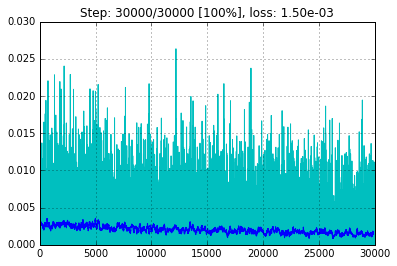

CPU times: user 1h 41min 35s, sys: 18min 51s, total: 2h 27s
Wall time: 1h 48min 59s


In [21]:
%%time
model.train(
    dataset    = tr_dataset,
    aug        = tr_aug.augment,
    margin     = margin,
    step_num   = 30000, 
    batch_size = 64, 
    lr         = 3e-6)
model.save("models/hash_model/003/")

## Test quality

In [7]:
%%time
dbase = DataBase()
dbase.build(model, tr_dataset.train_images)
te_aug  = Augmentator(rate=.60)
request = te_aug.augment(dbase.images)

CPU times: user 52.4 s, sys: 1.25 s, total: 53.6 s
Wall time: 54.1 s


In [8]:
%%time
ind, dist  = dbase.query(request, 3)

def get_quality(ind, k):
    assert 0 < k <= ind.shape[1]
    err = 0
    N   = len(ind)
    for i in range(N):
        ok = False
        for j in range(k):
            if i==ind[i,j]:
                ok = True
        err+= not ok
    return ((N-err)/N*100)

print("Images  : %s" % list(dbase.images.shape))
print("Aug rate: %.2f" % te_aug._rate)
for k in range(1, ind.shape[1]+1):
    print("Quality@%d: %.1f%%" % (k, get_quality(ind, k)))
print('-'*50)

Images  : [6000, 128, 128, 1]
Aug rate: 0.60
Quality@1: 93.4%
Quality@2: 96.8%
Quality@3: 97.9%
--------------------------------------------------
CPU times: user 9.93 s, sys: 132 ms, total: 10.1 s
Wall time: 10.7 s


Searching known augmented coins:
average distance: 0.47


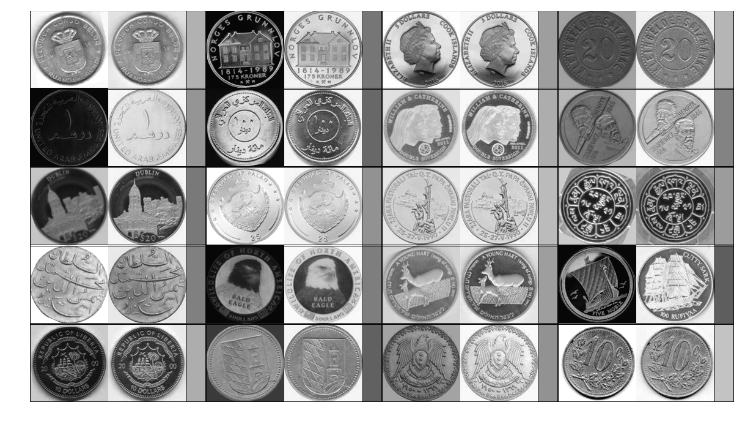

In [9]:
def show_results(images, max_k=0, aug=True):
    if aug:
        request = te_aug.augment(images)
    else:
        request = np.copy(images)
    ind, dist  = dbase.query(request, 3)
    per = np.random.choice(range(len(ind)), len(ind), replace=False)
    im1 = request[per]
    for k in range(0, max_k+1):
        print("average distance: %.2f" % np.mean(dist[:,k]))
        im2 = dbase.images[ind[:,k]][per]
        sim = 1-dist[:,k][per]
        num = 20
        im1 = im1[:num]
        im2 = im2[:num]
        sim = sim[:num]
        show_similarity(im1, im2, sim, cols=4)

print("Searching known augmented coins:")
show_results(dbase.images)

In [10]:
# print("Search unknown coins:")
# show_results(tr_dataset.train_images, max_k=1, aug = False)

## Restore model

In [6]:
model.restore("models/hash_model/003/")

INFO:tensorflow:Restoring parameters from models/hash_model/003/
